In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from tqdm import tqdm

from utils.traj_utils import calc_alpha, extract_traj_V2, calc_bond_vectors, calc_bondvec_corr, calc_persistence_length
from utils.vis_utils import plot_Rg_evol

%matplotlib inline

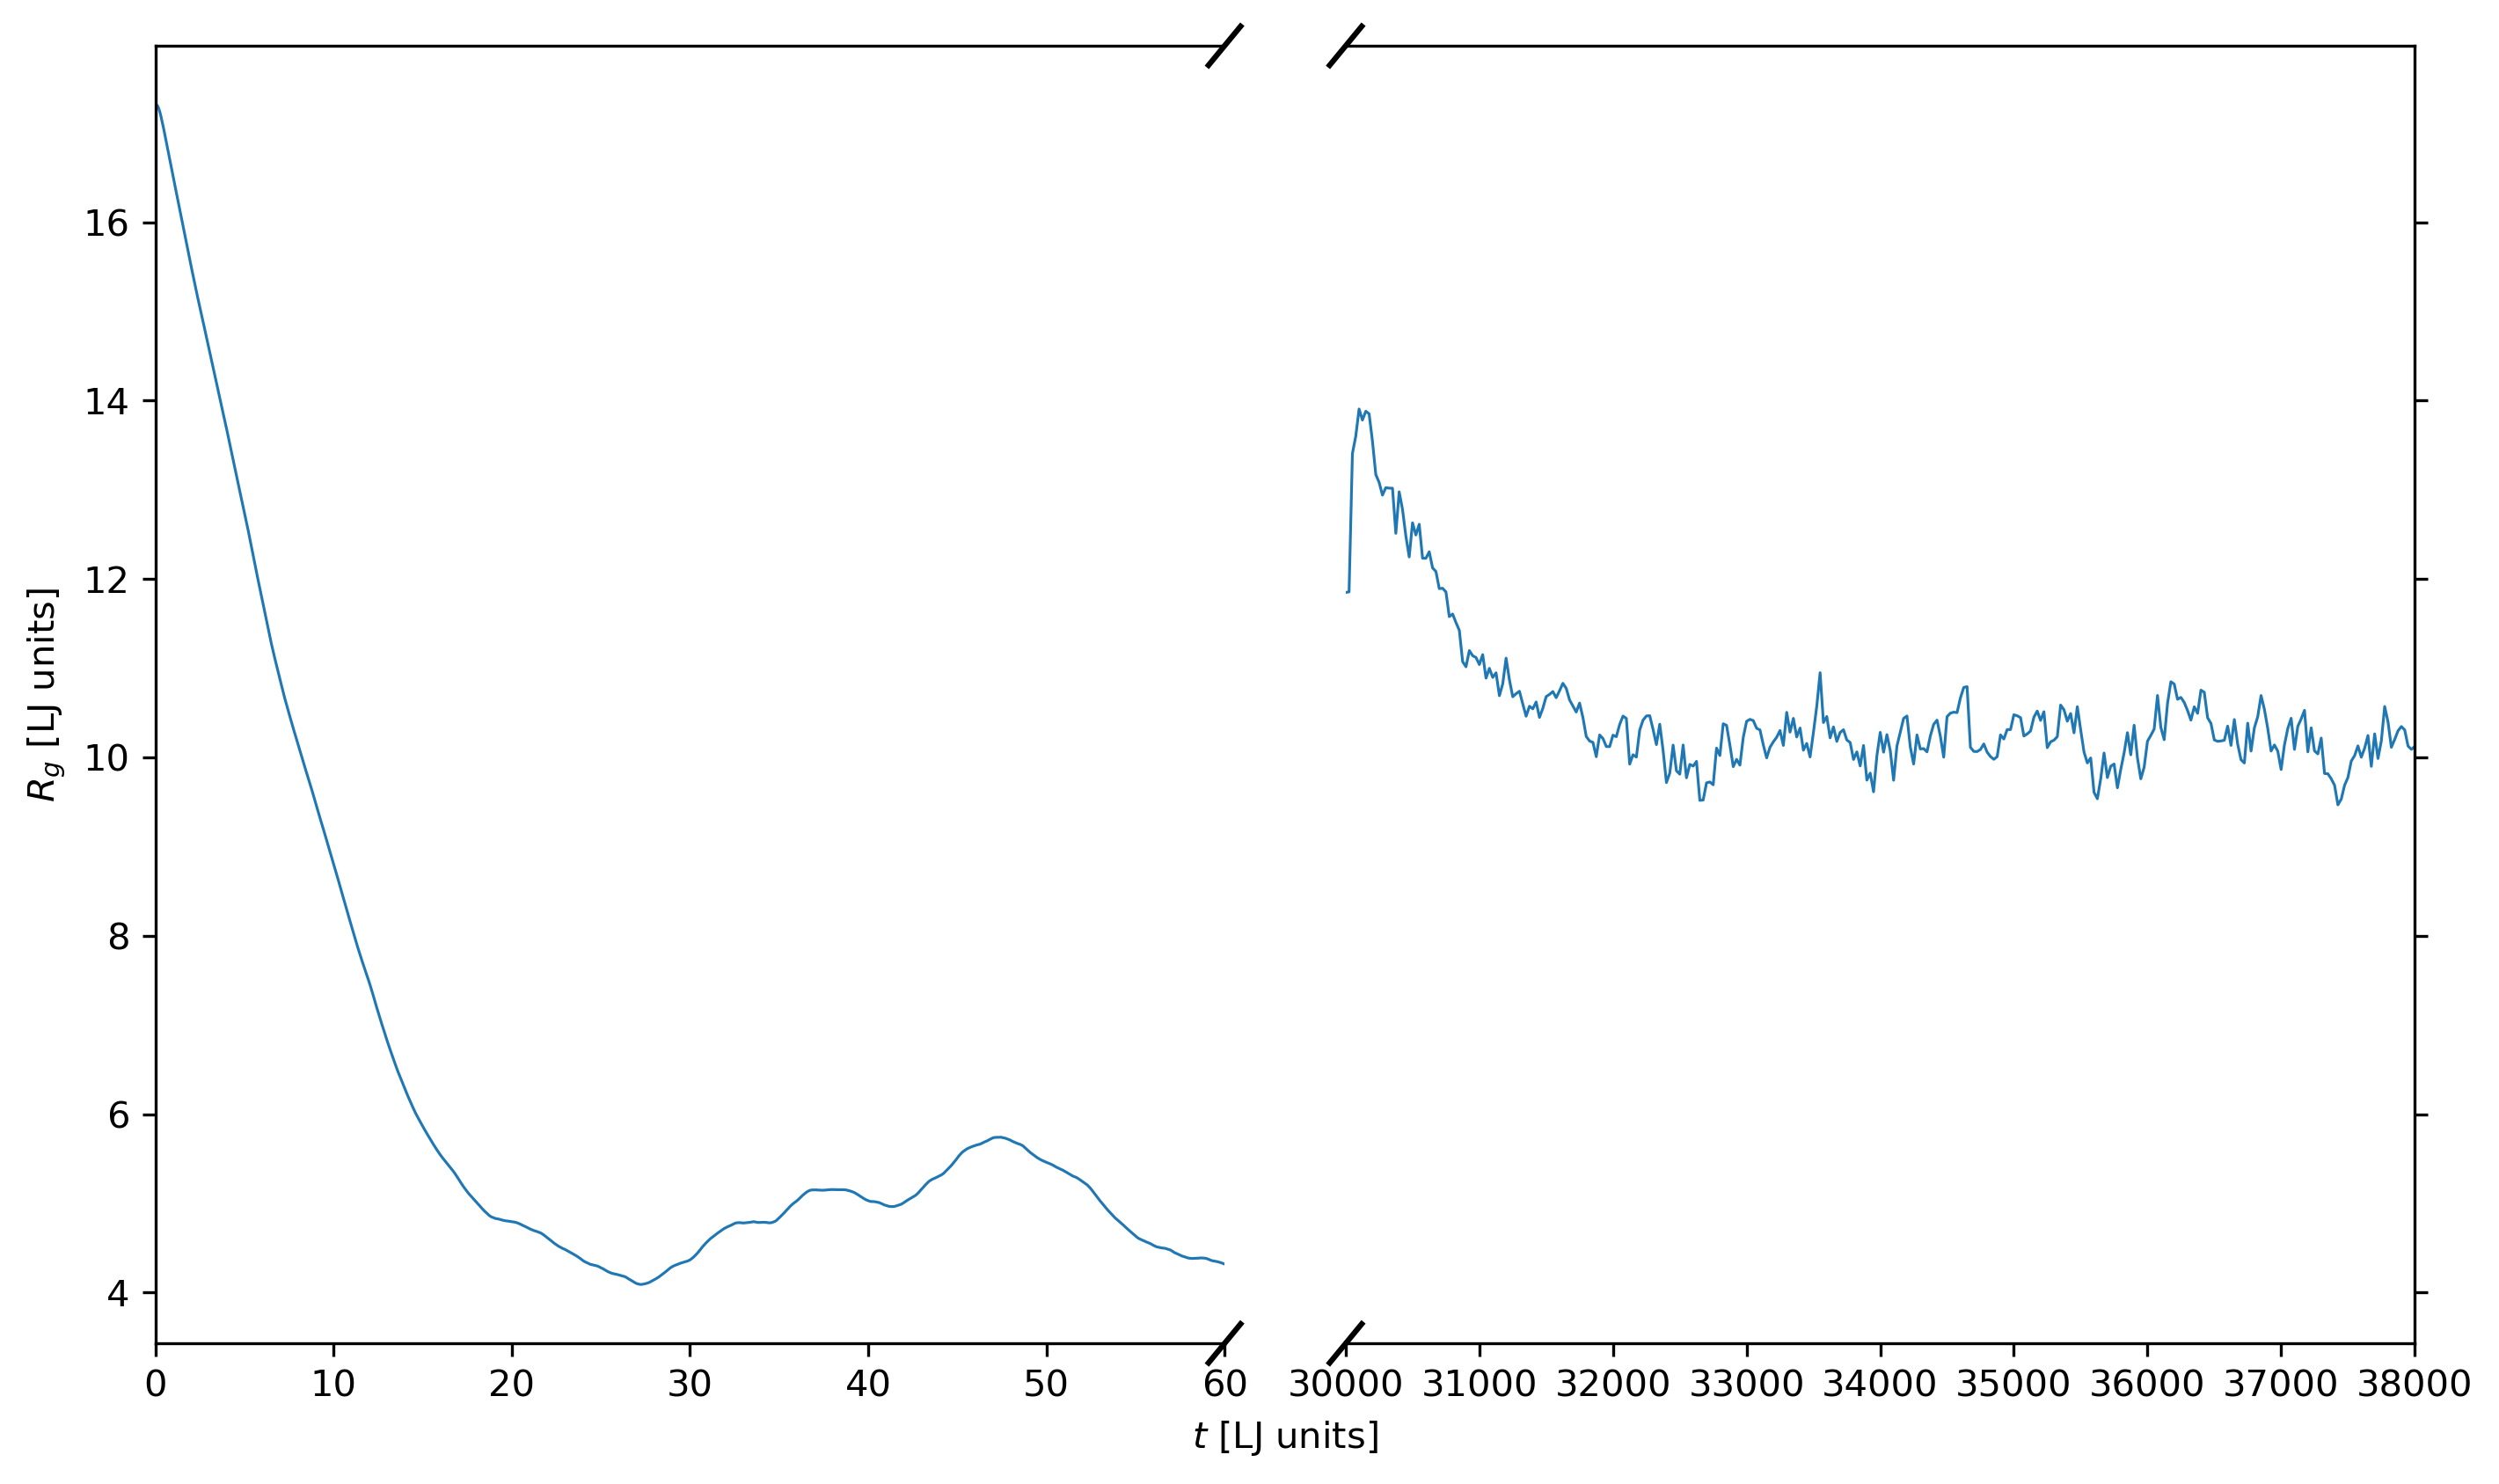

In [2]:
plot_Rg_evol('.', dt_eq=1e-5, dt_pr=5e-3, prod_start=6e6)

In [4]:
run_dirs = [dir for dir in os.listdir() if dir.startswith('RUN_')]

for r in tqdm(run_dirs):
    extract_traj_V2(
        num_header=9,
        num_atoms=120,
        dump_file=f'{r}/dump.lammpstrj',
        save_dir=f'{r}',
    )

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


In [7]:
cutoff = 1.12
window = 300

frac_ads = np.array([
    calc_alpha(
        np.load(f'{run}/atom_traj.npy'),
        np.loadtxt(f'{run}/atom_types.txt'),
        chain_type=1,
        ion_type=2,
        cutoff=cutoff,
        window=window,
    ) for run in run_dirs
]).mean(axis=0)

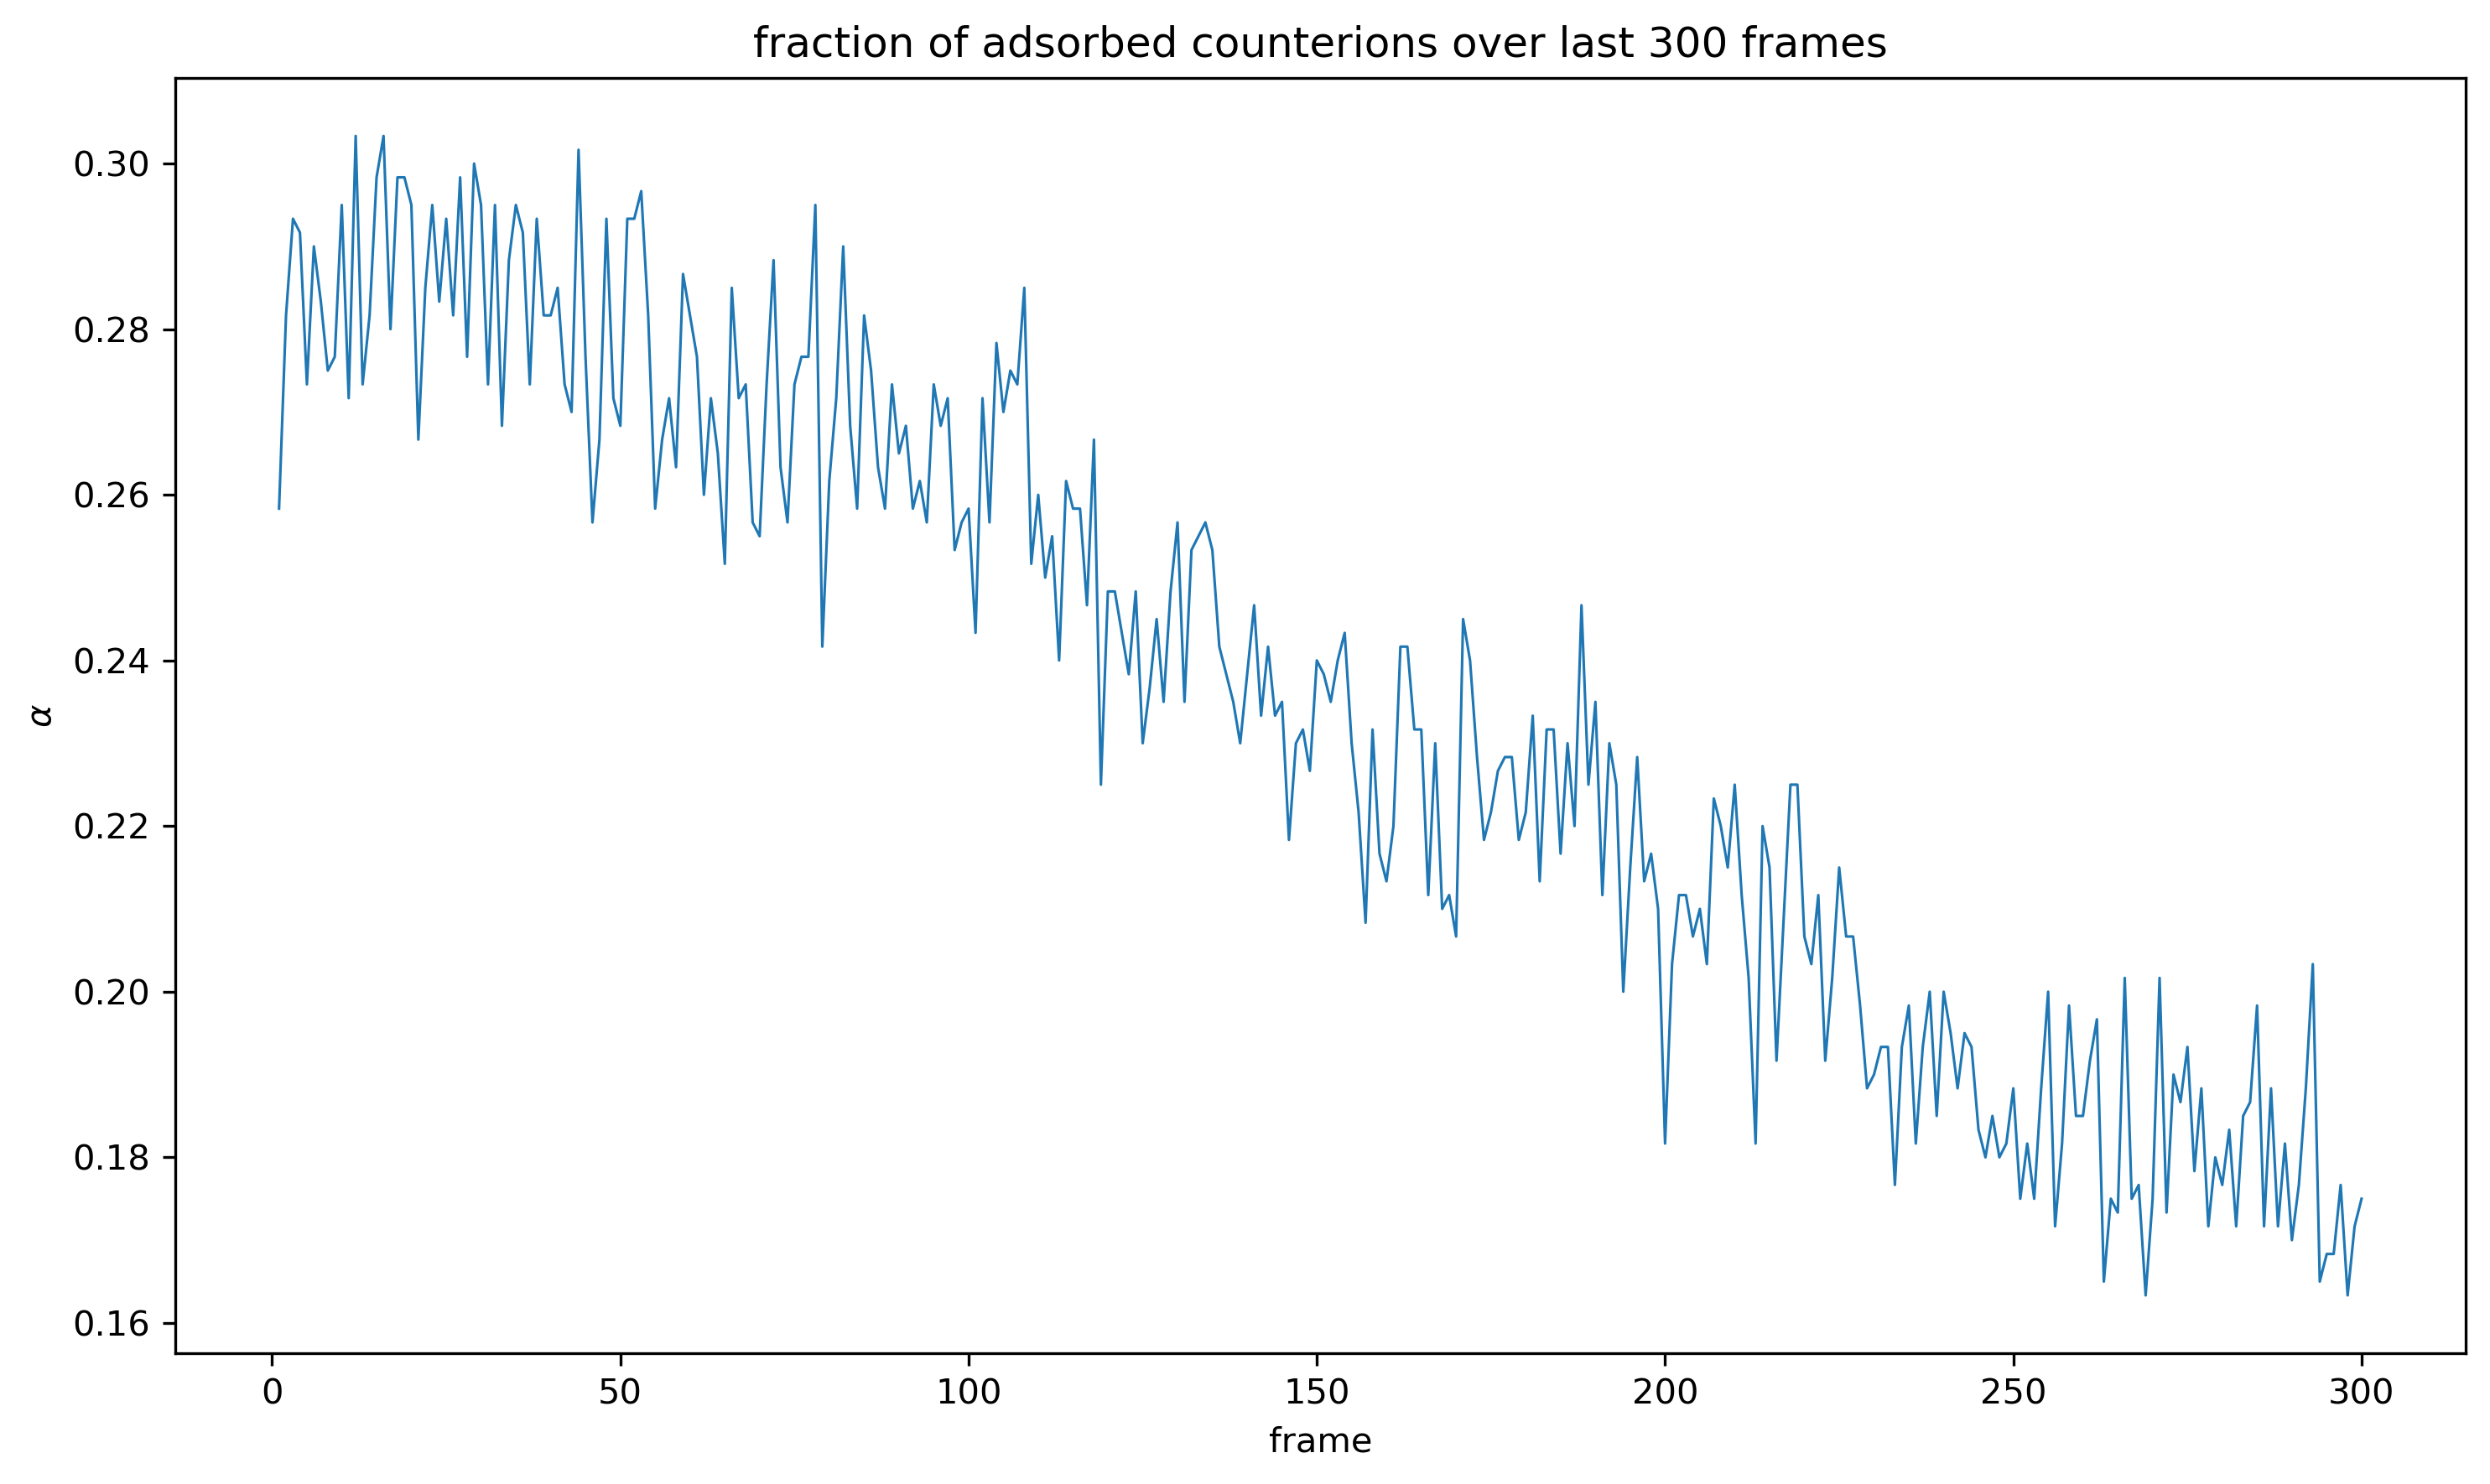

In [8]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

ax.plot(np.arange(1, window+1), frac_ads, linewidth=0.75)
ax.set_title(f'fraction of adsorbed counterions over last {window} frames')
ax.set_xlabel('frame')
ax.set_ylabel(r'$\alpha$')
fig.tight_layout()

In [9]:
traj = np.load('RUN_01/atom_traj.npy')
types = np.loadtxt('RUN_01/atom_types.txt')
chain_traj = traj[types[:, 1] == 1, :, -window:]
ions_traj = traj[types[:, 1] == 2, :, -window:]
dist = np.zeros((ions_traj.shape[0], window))
for t in range(window):
    count = 0
    for i, ion in enumerate(ions_traj[:, :, t]):
        xi, yi, zi = ion[0], ion[1], ion[2]
        xc, yc, zc = chain_traj[:, 0, t], chain_traj[:, 1, t], chain_traj[:, 2, t]
        dist[i, t] = np.sqrt((xc - xi) **2 + (yc - yi) ** 2 + (zc - zi) ** 2).min()
#         dist[i, t] = np.abs(np.linalg.norm(ion - chain_traj[:, :, t])).min()

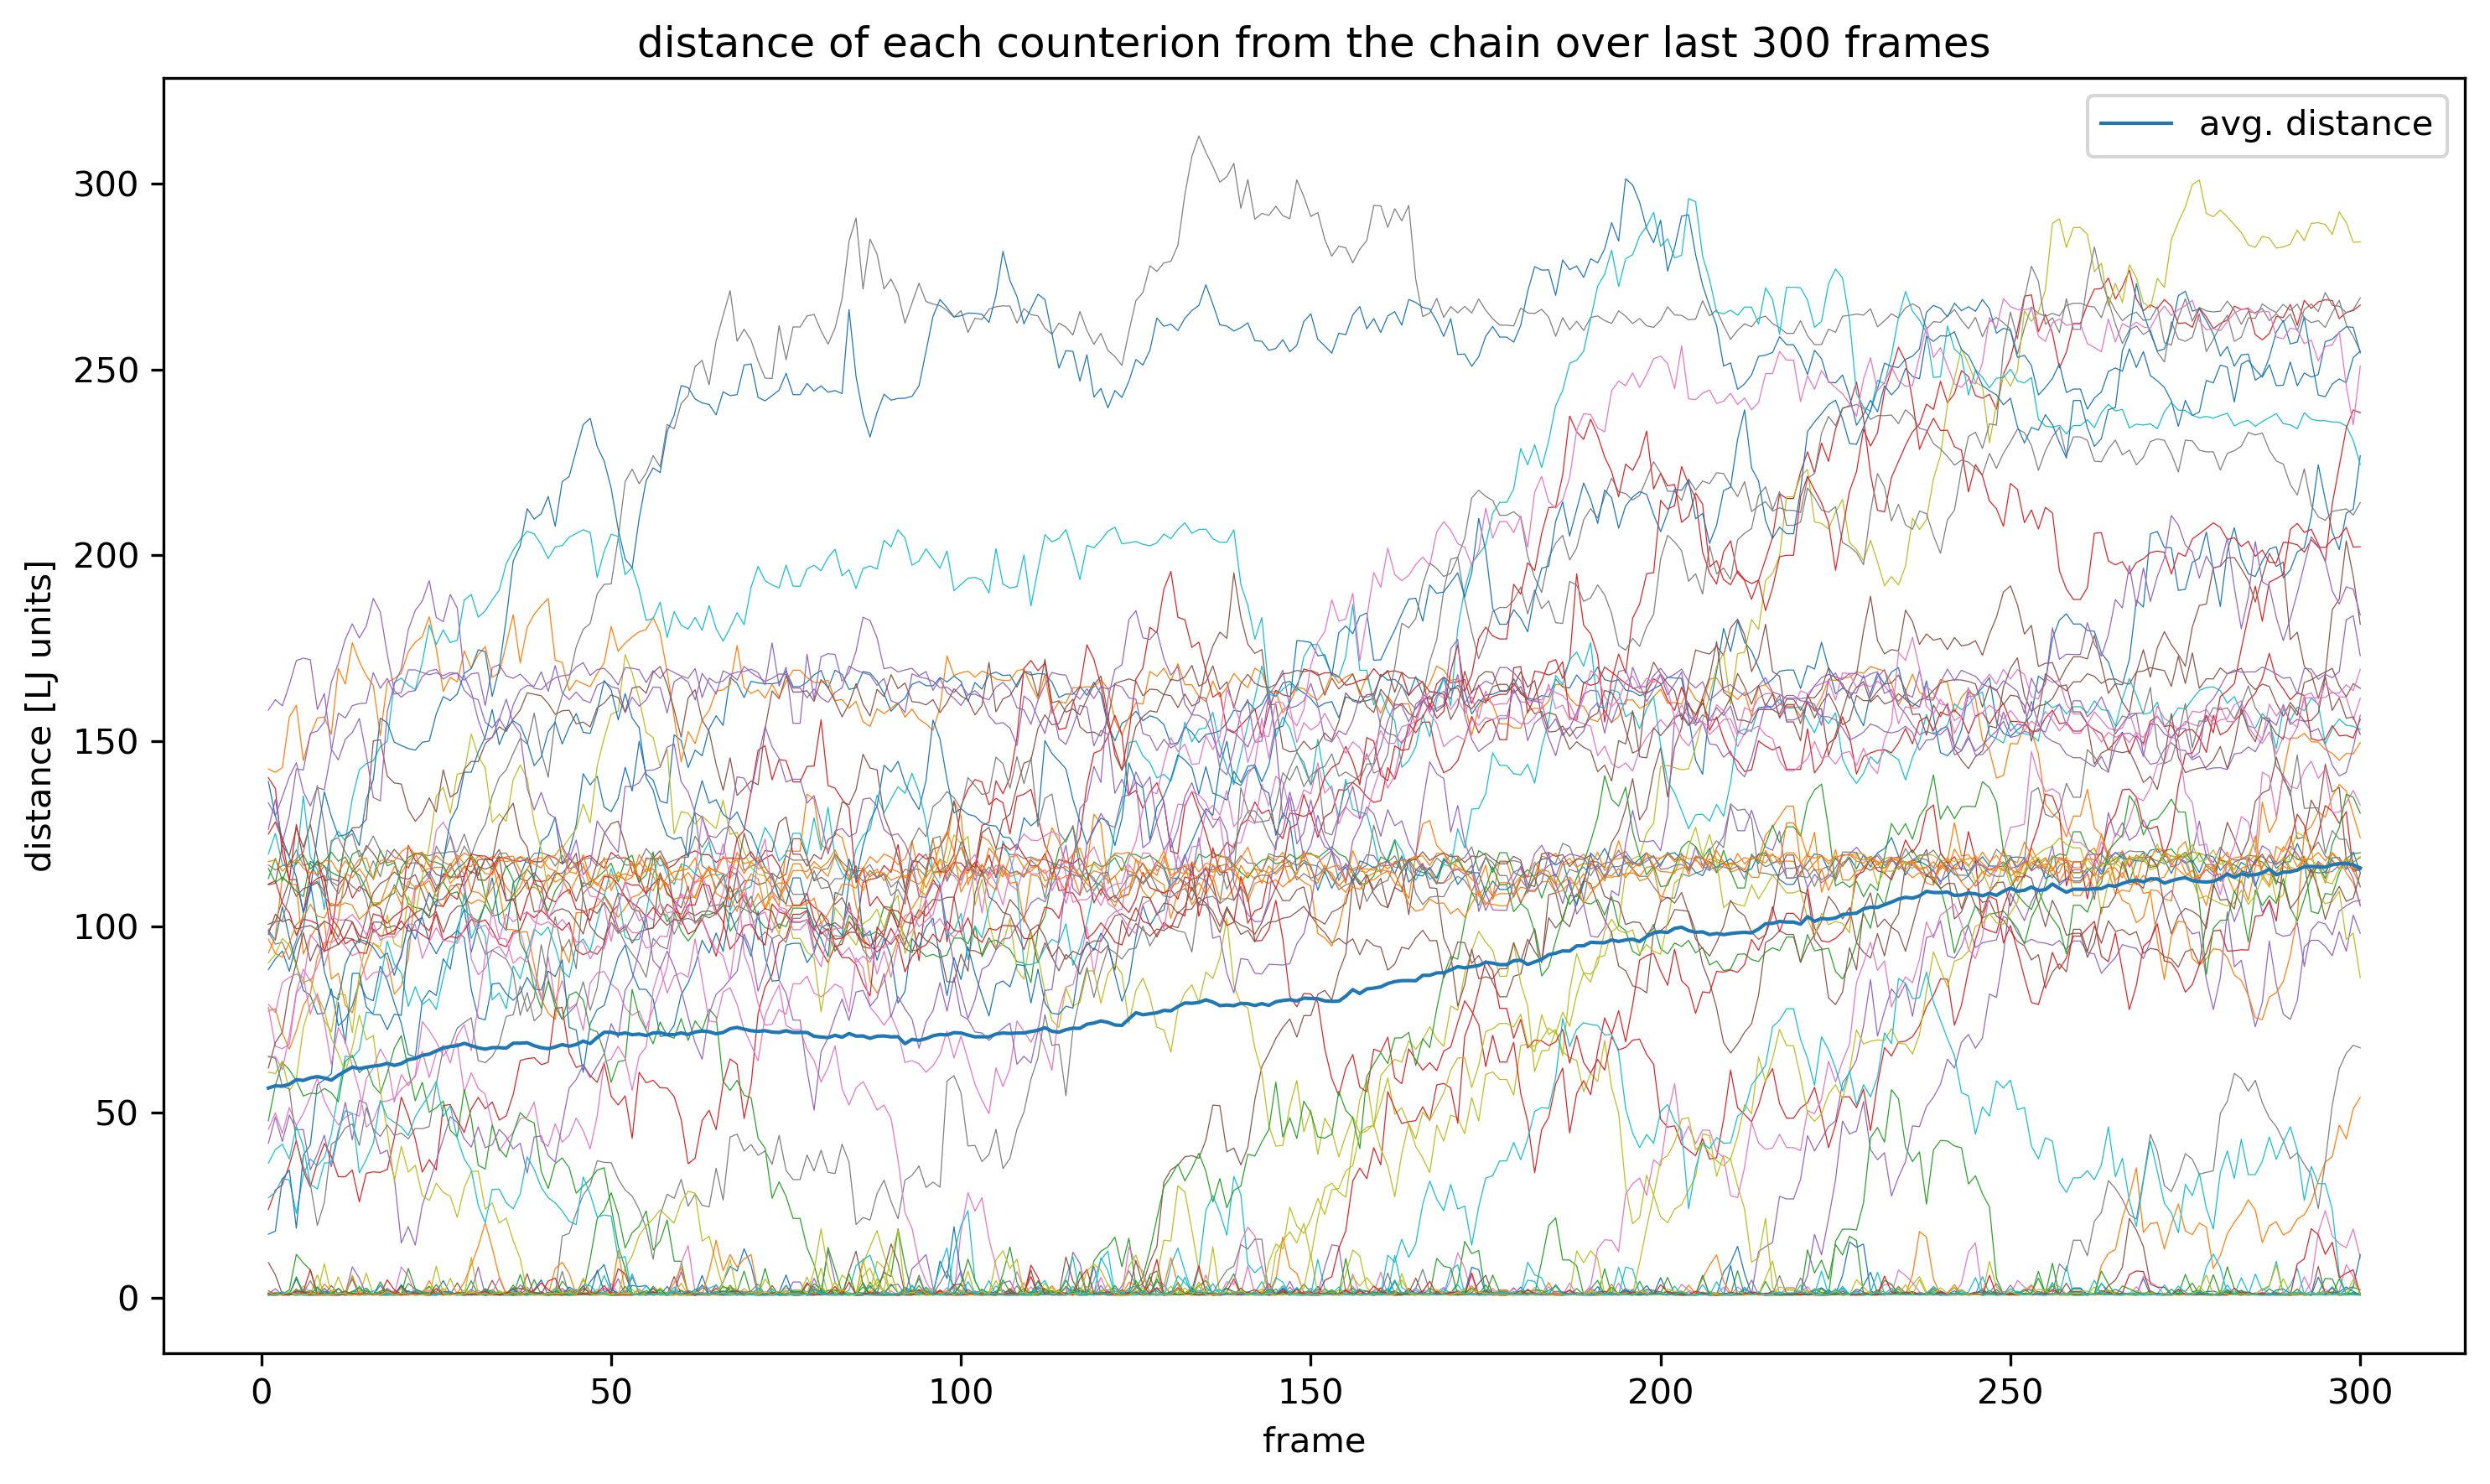

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

for i, data in enumerate(dist):
    ax.plot(np.arange(1, window + 1), data, linewidth=0.3)
    
ax.plot(np.arange(1, window + 1), dist.mean(axis=0), linewidth=1, label='avg. distance')
ax.set_title(f'distance of each counterion from the chain over last {window} frames')
ax.set_xlabel('frame')
ax.set_ylabel('distance [LJ units]')
ax.legend()
fig.tight_layout()

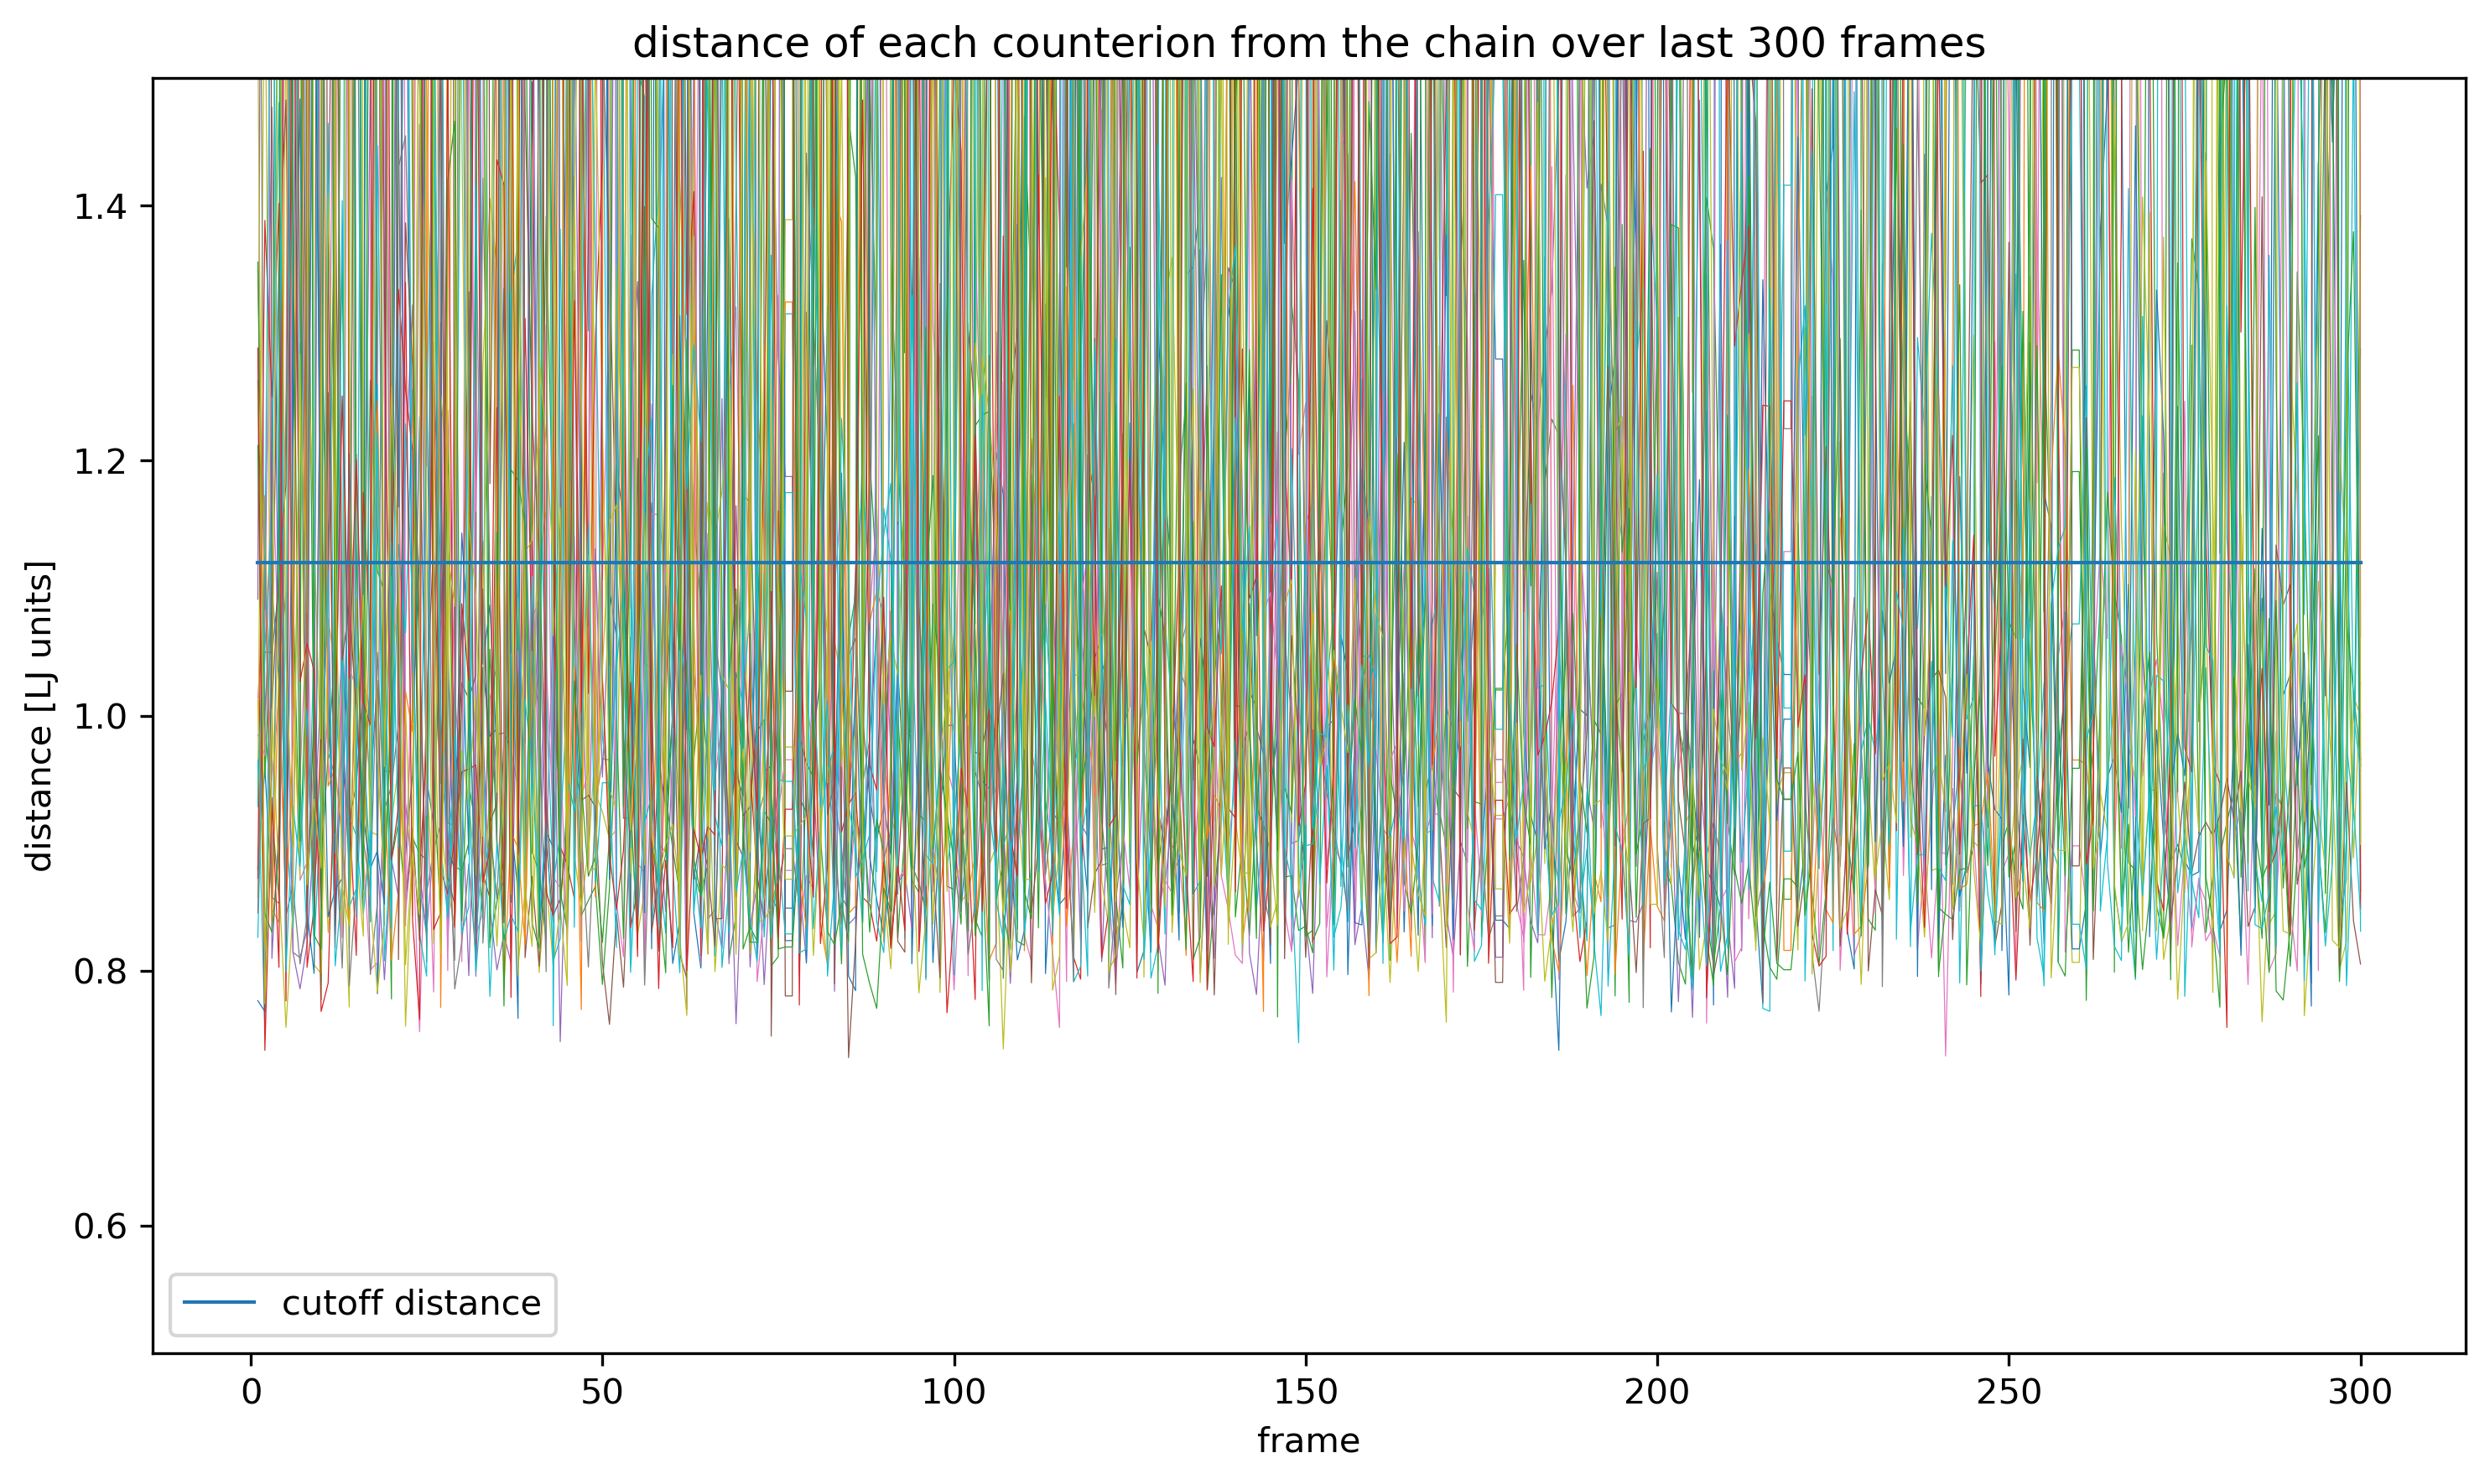

In [12]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

for i, data in enumerate(dist):
    ax.plot(np.arange(1, window + 1), data, linewidth=0.3)
    
ax.plot(np.arange(1, window + 1), [cutoff] * window, linewidth=1, label='cutoff distance')
ax.set_title(f'distance of each counterion from the chain over last {window} frames')
ax.set_xlabel('frame')
ax.set_ylabel('distance [LJ units]')
ax.set_ylim(0.5, 1.5)
ax.legend()
fig.tight_layout()

In [2]:
traj = np.load('RUN_01/atom_traj.npy')
bondvecs = calc_bond_vectors(traj)
C = calc_bondvec_corr(bondvecs[:, :, -1])

In [3]:
filenames = [f'{run}/atom_traj.npy' for run in os.listdir('.') if run.startswith('RUN_')]
C = np.array([calc_bondvec_corr(calc_bond_vectors(np.load(fname)[:60, :, :])[:, :, -1]) for fname in filenames]).mean(axis=0)

In [4]:
C.shape

(59,)

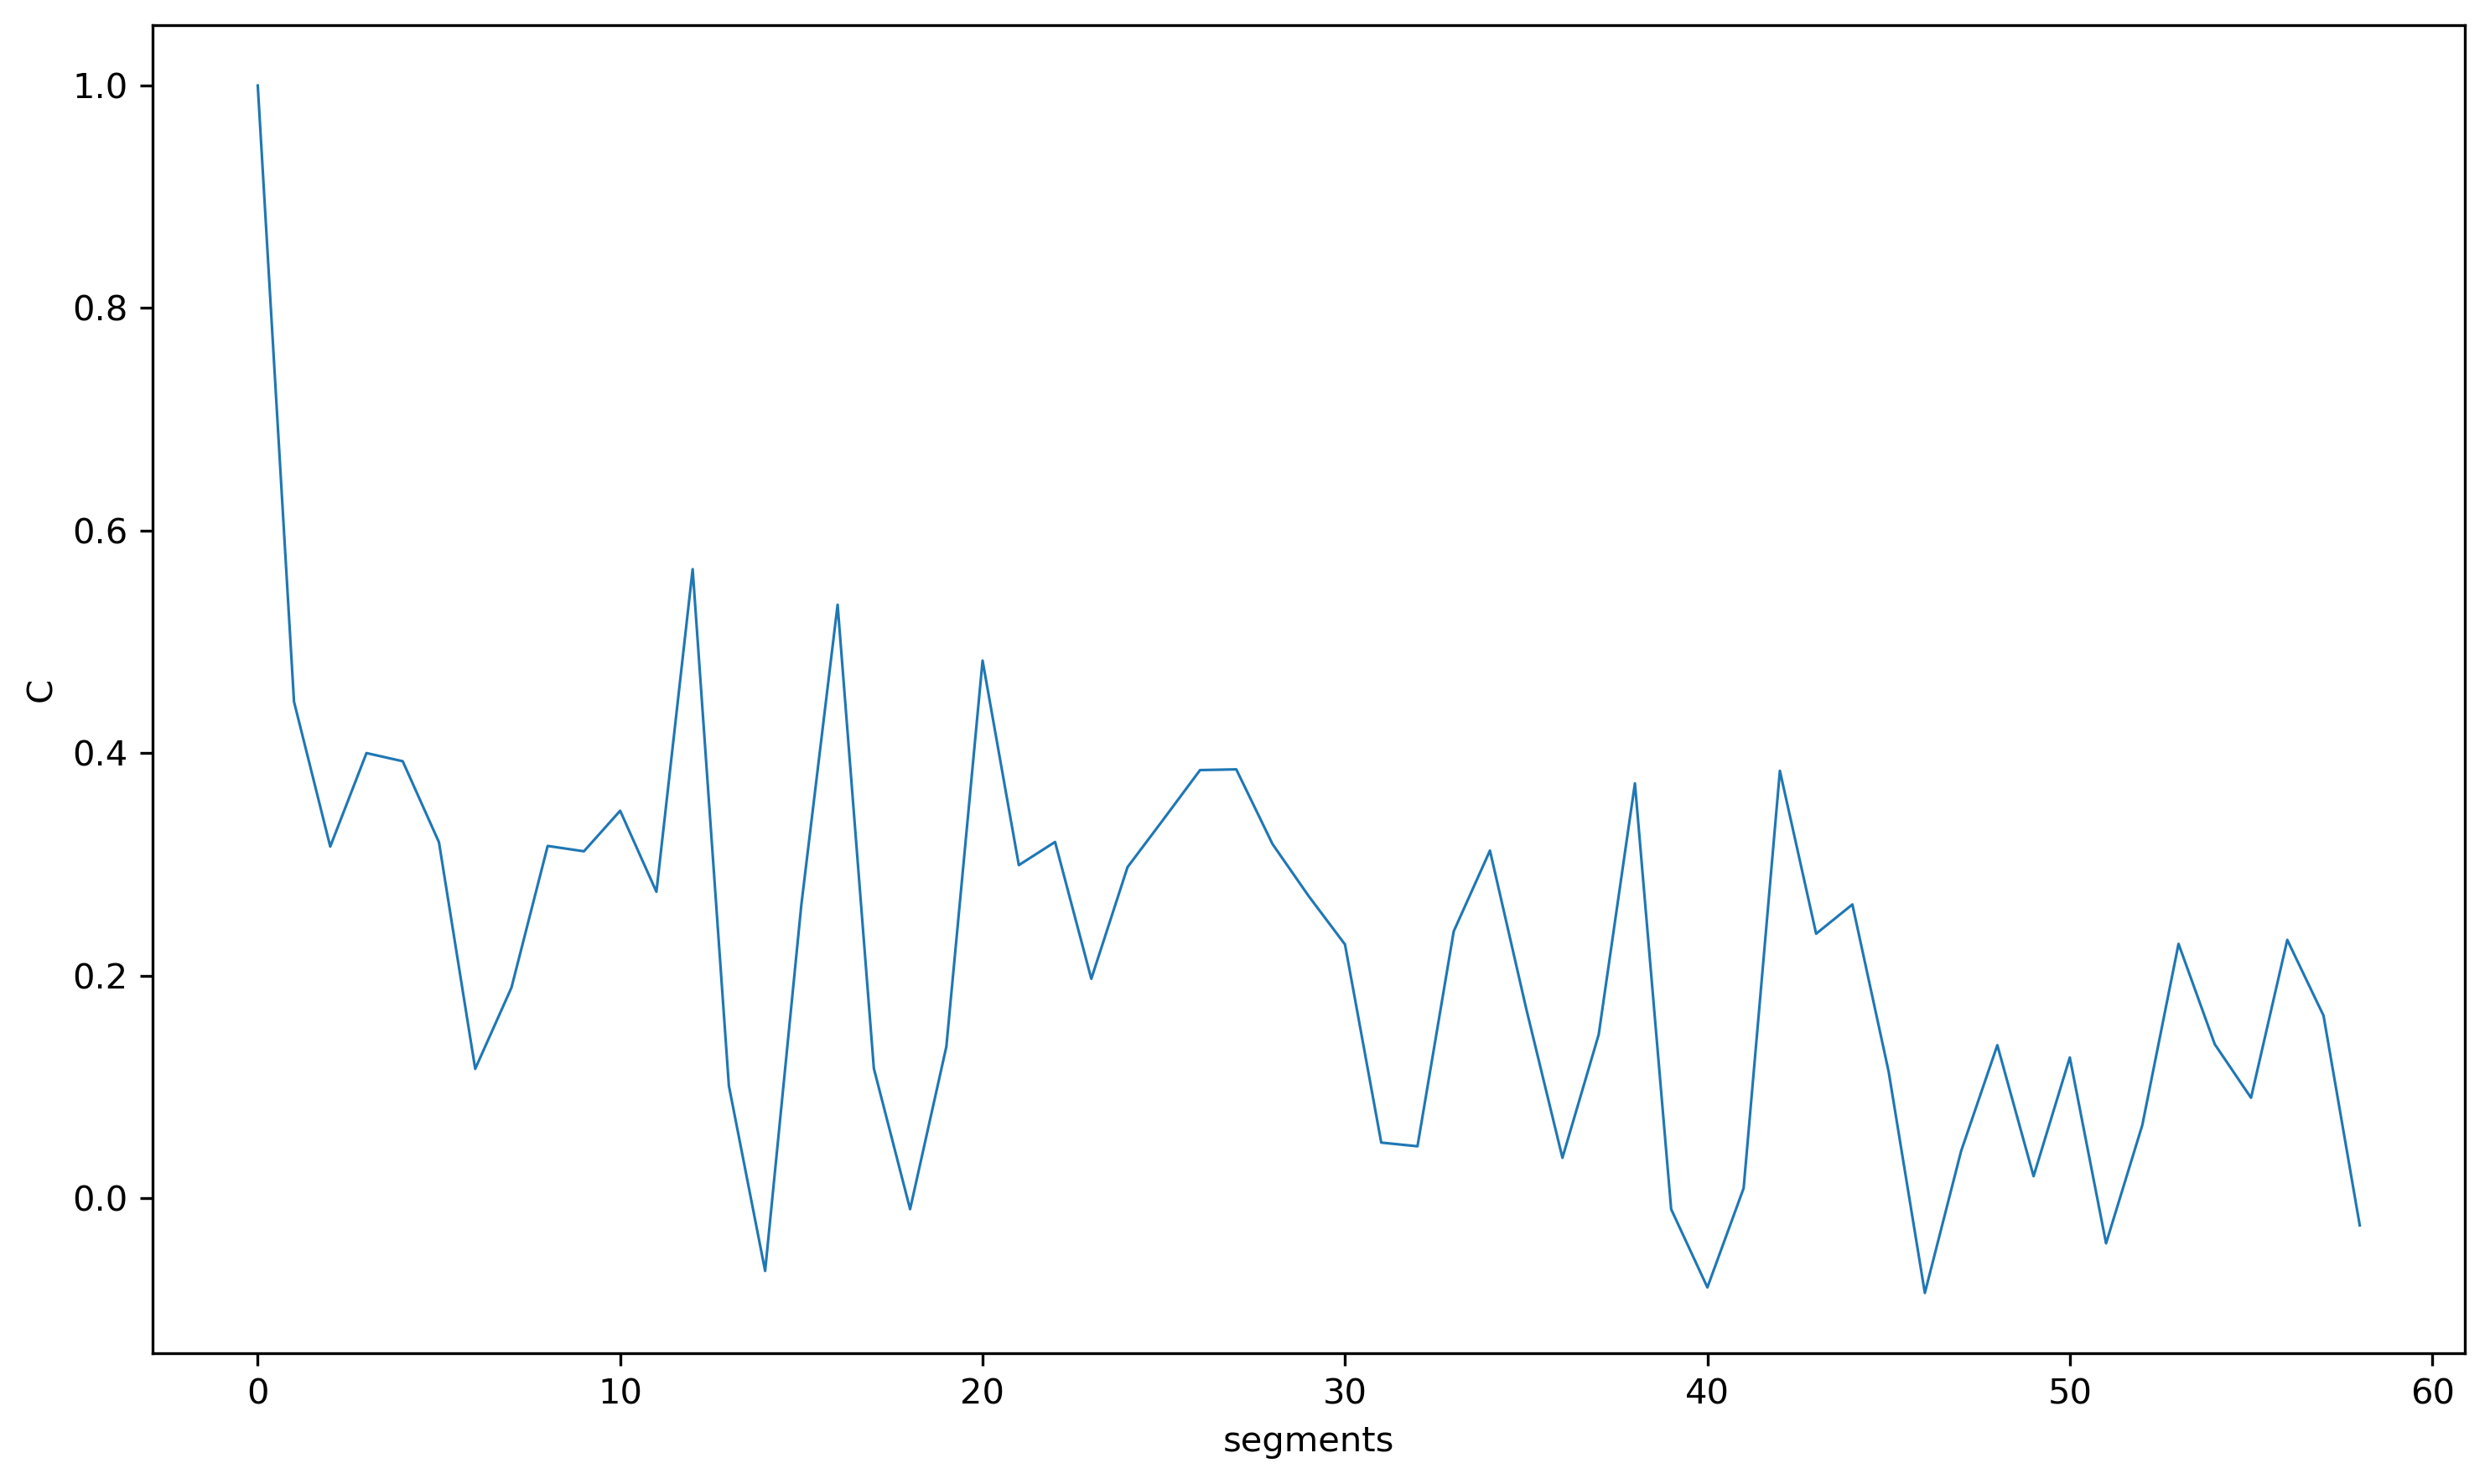

In [5]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

ax.plot(range(len(C)), C, linewidth=0.75)    
ax.set_xlabel('segments')
ax.set_ylabel('C')

fig.tight_layout()

In [8]:
lp = calc_persistence_length(traj[: ,:, -1])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed